In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import pints
import pints.toy as toy

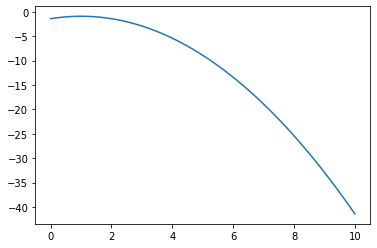

-41.418938533204674

In [3]:
# Parameters (& hyper parameters)
theta_data = [28, 8, -3, 7, -1, 1, 18, 12] # measured average score for each school
sigma_data = [15, 10, 16, 11, 9, 11, 10, 18] # measured score SD for each school
mu = 1 # overall mean score
tau = 1 # overall score SD

# What is gaussianlogprior?
prior = pints.GaussianLogPrior(mu, tau)
nums = [n/10 for n in np.linspace(0,100)]
test = [prior([n]) for n in nums]
#testcdf = prior.cdf()
plt.figure()
plt.plot(nums, test)
#plt.plot(nums, testcdf)
plt.show()

prior([10])

For our case, the likelihood is 
$$\begin{eqnarray}
\mathcal{L} &=& P(y_j, \theta_j, \mu, \tau) 
\\&=& \prod_{j=1}^8 P(y_j|\theta_j,\sigma_j) \cdot P(\theta_j|\mu,\tau) \cdot P(\mu) \cdot P(\tau)
\\&=& \prod_{j=1}^8 \Bigg(\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(y_j-\theta_j)^2}{2\sigma_j^2}} \cdot \frac{1}{\sqrt{2\pi\tau^2}}e^{\frac{-(\theta_j-\mu)^2}{2\tau^2}} \cdot \frac{1}{\sqrt{2\pi\sigma_\mu^2}}e^{\frac{-(\mu-\mu_\mu)^2}{2\sigma_\mu^2}} \cdot \frac{1}{\sqrt{2\pi\sigma_\tau^2}}e^{\frac{-(\mu-\mu_\tau)^2}{2\sigma_\tau^2}}\Bigg)
\end{eqnarray}$$

And so the log likelihood is  
$$\begin{eqnarray}
\log\mathcal{L} &=& \log\bigg(\sum_{j=1}^8 P(y_j|\theta_j,\sigma_j)P(\theta_j|\mu,\tau)P(\mu)P(\tau)\bigg)
\\&=& \sum_{j=1}^8 \log\bigg(\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(y_j-\theta_j)^2}{2\sigma_j^2}}\bigg)
+ \sum_{j=1}^8 \log\bigg(\frac{1}{\sqrt{2\pi\tau^2}}e^{\frac{-(\theta_j-\mu)^2}{2\tau^2}}\bigg)
+ \log\bigg(\frac{1}{\sqrt{2\pi\sigma_\mu^2}}e^{\frac{-(\mu-\mu_\mu)^2}{2\sigma_\mu^2}}\bigg)
+ \log\bigg(\frac{1}{\sqrt{2\pi\sigma_\tau^2}}e^{\frac{-(\mu-\mu_\tau)^2}{2\sigma_\tau^2}}\bigg)
\end{eqnarray}$$

Note that the exponentials can be further separated from the fractions if required, using the log sum law: $\log(ab) = \log(a)+\log(b)$

In [4]:
# Stolen mostly from pints eightschools

def loglikelihood_8schools(x, y_data):
    # x is proposed parameters, we're finding numerator of Bayes' rule
    if len(x) != 10:
        raise ValueError('Input parameters must be of length 10.')
    mu = x[0] # overall mean
    tau = x[1] # overall variance
    thetas = x[2:] # mean per school
    lk_of_theta = 0
    lk_of_data = 0
    # priors
    log_prior = pints.GaussianLogPrior(mu, tau) # prior pdf of theta
    mu_log_prior = pints.GaussianLogPrior(0,5) # prior pdf, centred on zero (no avg effect)
    tau_log_prior = pints.HalfCauchyLogPrior(0,5) # prior pdf, why centre zero???
    
    lk_of_mu = mu_log_prior([mu]) # log likelihood of mu
    lk_of_tau = tau_log_prior([tau]) # log likelihood of tau

    # nb. theta_tilde is the proposed theta (rather than data theta) I think?
    for i, theta_tilde in enumerate(thetas): # go through each proposed school mean
        lk_of_theta += log_prior([theta_tilde]) # log likelihood of theta

        log_prior_2 = pints.GaussianLogPrior(theta_tilde, sigma_data[i]) 
        lk_of_data += log_prior_2([y_data[i]]) # log likelihood of data given theta?

    return lk_of_mu + lk_of_tau + lk_of_theta + lk_of_data


In [5]:
# Let's compare this to pints to make sure it works
customtest = loglikelihood_8schools(np.ones(10), theta_data)
pintsmodel = toy.EightSchoolsLogPDF()
pintstest = pintsmodel(np.ones(10))

Some MCMC techniques use the local gradient to choose the next step size, so we need the sensitivity of the log probability with respect to each parameter. `evaluateS1` returns the LogPDF, plus the partial derivatives of the LogPDF with respect to the parameters. The partial derivatives in this case are given here.  

Only two terms of $\log\mathcal{L}$ have $\mu$ in; the rest differentiate to zero so can be ignored.

$$\begin{eqnarray}\require{cancel}
\frac{\partial \mathcal{L}}{\partial \mu} &=& \cancel{\sum_{j=1}^8 \log\bigg(\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(y_j-\theta_j)^2}{2\sigma_j^2}}\bigg)}
+ \sum_{j=1}^8 \log\bigg(\frac{1}{\sqrt{2\pi\tau^2}}e^{\frac{-(\theta_j-\mu)^2}{2\tau^2}}\bigg)
+ \log\bigg(\frac{1}{\sqrt{2\pi\sigma_\mu^2}}e^{\frac{-(\mu-\mu_\mu)^2}{2\sigma_\mu^2}}\bigg)
+ \cancel{\log\bigg(\frac{1}{\sqrt{2\pi\sigma_\tau^2}}e^{\frac{-(\tau-\mu_\tau)^2}{2\sigma_\tau^2}}\bigg)}
\\&=& \frac{\partial}{\partial \mu} \bigg( \cancel{\log \frac{1}{\sqrt{2\pi\tau^2}}} + \log(e^{\frac{-(\theta_j-\mu)^2}{2\tau^2}}) + \cancel{\log \frac{1}{\sqrt{2\pi\sigma_\mu^2}}} + \log(e^{\frac{-(\mu-\mu_\mu)^2}{2\sigma_\mu^2}}) \bigg)
\\&=& \frac{\partial}{\partial \mu} \bigg( \log(e^{\frac{-(\theta_j-\mu)^2}{2\tau^2}}) + \log(e^{\frac{-(\mu-\mu_\mu)^2}{2\sigma_\mu^2}}) \bigg)
\\&=& \frac{\partial}{\partial \mu} \bigg(\frac{-(\theta_j-\mu)(\theta_j-\mu)}{2\tau^2} + \frac{-(\mu-\mu_\mu)(\mu-\mu_\mu)}{2\sigma_\mu^2}\bigg)
\\&=& \frac{1}{2\tau^2} \frac{\partial}{\partial \mu} \bigg(-(\theta_j-\mu)(\theta_j-\mu)\bigg) + \frac{1}{2\sigma_\mu^2} \frac{\partial}{\partial \mu} \bigg(-(\mu-\mu_\mu)(\mu-\mu_\mu)\bigg)
\\&=& \frac{-2\theta_j+2\mu}{2\tau^2} + \frac{-2\mu+2\mu_\mu}{2\sigma_\mu^2}
\\&=& \frac{\mu-\theta_j}{\tau^2} + \frac{\mu_\mu-\mu}{\sigma_\mu^2}
\end{eqnarray}$$

$\theta$ can be calculated the same way as above (for each j).

$$\begin{eqnarray}
\frac{\partial \mathcal{L}}{\partial \theta_j} &=& \frac{\partial}{\partial \theta_j}\bigg( \log e^{\frac{-(\theta_j-\mu)^2}{2\sigma_j^2}}\bigg) + \frac{\partial}{\partial \theta_j}\bigg( \log e^{\frac{-(y_j-\theta_j)^2}{2\sigma_j^2}} \bigg)
\\&=& \frac{\partial}{\partial \theta_j}\bigg({\frac{-(\theta_j-\mu)(\theta_j-\mu)}{2\sigma_j^2}}\bigg) + \frac{\partial}{\partial \theta_j}\bigg({\frac{-(y_j-\theta_j)(y_j-\theta_j)}{2\sigma_j^2}} \bigg)
\\&=& \frac{\theta_j-y_j}{\sigma_j^2} + \frac{\mu-\theta_j}{\tau^2}
\end{eqnarray}$$  

I'll split $\tau$ into two parts, so as to simplify the working. Part 1 is the probability of the estimated results, $\theta_j$, given $\tau$. Here we use the chain rule, $\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z}\frac{\partial z}{\partial x}$ with $z=\frac{1}{\sqrt{2\pi\tau^2}}$.
Note that I have an additional minus sign here on line 4 that I can't seem to locate the origin of. If found please return.

$$\begin{eqnarray}
\frac{\partial \mathcal{L}1}{\partial \tau} &=& \frac{\partial}{\partial \tau}\bigg( \log\frac{1}{\sqrt{2\pi\tau^2}} + \log e^{\frac{-(\theta_j-\mu)^2}{2\tau^2}} \bigg)
\\&=& \frac{\partial}{\partial z} \log z \cdot \frac{\partial}{\partial \tau} \frac{1}{\sqrt{2\pi\tau^2}} + \frac{\partial}{\partial \tau} {\frac{-(\theta_j-\mu)^2}{2\tau^2}}
\\&=& \bigg(\sqrt{2\pi\tau^2}\bigg)\bigg(\frac{1}{\tau^2\sqrt{2\pi}}\bigg) + \frac{(\theta_j-\mu)^2}{\tau^3}
\\&=&\frac{(\theta-\mu)^2}{\tau^3} - \frac{1}{\tau}
\\&=&\frac{(\theta-\mu)^2-\tau^2}{\tau^3}
\end{eqnarray}$$  

Part 2 is the probability of $\tau$ given the underlying probability distribution (chosen by the modeller). In this case we're using a half-Cauchy distribution centred on a mean that I have (foolishly) called $\mu_\tau$ with a variance (kind of: not technically a variance but whatever) of $\sigma_\tau$. This is a fun one as it uses both the chain rule and the quotient rule for differentiation. I bet you never thought you'd be revising those today.

$$\begin{eqnarray}
\frac{\partial \mathcal{L}2}{\partial \tau} &=& \frac{\partial}{\partial \tau} \log \bigg( \frac{\sigma_\tau^2}{(\tau-\mu)^2 + \sigma_\tau^2} \bigg)
\\&=& \frac{\partial}{\partial z} \cdot \log (z) \frac{\partial}{\partial \tau} \bigg( \frac{\sigma_\tau^2}{(\tau-y_\tau)^2 + \sigma_\tau^2} \bigg) \ where \ z = \frac{\sigma_\tau^2}{(\tau-\mu_\tau)^2 + \sigma_\tau^2}
\\&=& \frac{(\tau-\mu_\tau)^2 + \sigma_\tau^2}{\sigma_\tau^2} \cdot \sigma_\tau^2 \cdot \frac{\partial}{\partial \tau} \bigg( \frac{1}{(\tau-\mu_\tau)^2 + \sigma_\tau^2} \bigg)
\\&=& ((\tau-\mu_\tau)^2 + \sigma_\tau^2) \cdot \frac{2\tau-2\mu_\tau}{((\tau-\mu_\tau)^2 + \sigma_\tau^2)^2}
\\&=& \frac{2\tau-2\mu_\tau}{(\tau-\mu_\tau)^2 + \sigma_\tau^2}
\\ \frac{\partial \mathcal{L}}{\partial \tau} &=& \frac{(\theta-\mu)^2-\tau^2}{\tau^3} + \frac{2\tau-2\mu_\tau}{(\tau-\mu_\tau)^2 + \sigma_\tau^2}
\end{eqnarray}$$  

In [20]:
# We'll make a logPDF class, and use th equations above in evaluateS1.
class pints8schools(pints.LogPDF):
    def __init__(self):
        self._n_parameters = 10
    def __call__(self, x, y_data=theta_data): 
        return loglikelihood_8schools(x, y_data)
    def n_parameters(self):
        return self._n_parameters
    def evaluateS1(self, x):
        mu = x[0]
        tau = x[1]
        thetas = x[2:]
        ys = theta_data
        sigmas = sigma_data
        
        logprob = loglikelihood_8schools(x, ys)
        
        dLdmu = (0-mu)/(5**2)
        dLdtau = (-2*tau)/(tau**2 + 5**2) 
        dLdtheta = []
        
        for j in range(len(thetas)):
            theta = thetas[j]
            y_j = ys[j]
            sigma = sigmas[j]
            dLdmu += (mu-theta)/tau**2
            dLdtau += ((theta-mu)**2 - tau**2)/tau**3
            dLdtheta.append(((theta-y_j)/sigma**2) + (mu-theta)/tau**2)
        
        return logprob, ([dLdmu] + [dLdtau] + dLdtheta)

ls = [np.ones(10), np.ones(10), np.ones(10)]
start_thetas = [arr.tolist() for arr in ls]
model = pints8schools()
pintsmodel = toy.EightSchoolsLogPDF()

pintstest1, pintstest2 = pintsmodel.evaluateS1(start_thetas[0])
test1, test2 = model.evaluateS1(start_thetas[0])
print('pints: %.5f  mine: %.5f logprob' % (pintstest1, test1))
for n in range(len(test2)):
    print('pints: %.5f  mine: %.5f' % (pintstest2[n], test2[n]))
print(pintstest2)
print(test2)

pints: -43.02226  mine: -43.02226 logprob
pints: -0.04000  mine: -0.04000
pints: -8.07692  mine: -8.07692
pints: 0.12000  mine: -0.12000
pints: 0.07000  mine: -0.07000
pints: -0.01562  mine: 0.01562
pints: 0.04959  mine: -0.04959
pints: -0.02469  mine: 0.02469
pints: 0.00000  mine: 0.00000
pints: 0.17000  mine: -0.17000
pints: 0.03395  mine: -0.03395
[-0.04, -8.076923076923077, 0.12, 0.07, -0.015625, 0.049586776859504134, -0.024691358024691357, 0.0, 0.17, 0.033950617283950615]
[-0.04, -8.076923076923077, -0.12, -0.07, 0.015625, -0.049586776859504134, 0.024691358024691357, 0.0, -0.17, -0.033950617283950615]


In [19]:
mcmc = pints.MCMCController(model, 3, start_thetas, method=pints.HamiltonianMCMC)
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

full_chains = mcmc.run()

Using Hamiltonian Monte Carlo
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0.333     0.333      0:00.0
2     123    0.5       0.5       0.5        0:00.0
3     183    0.6       0.6       0.6        0:00.0
100   6003   0.961     0.951     0.931      0:00.6
200   12003  0.960396  0.955     0.960396   0:01.3
300   18003  0.94      0.957     0.957      0:01.9
400   24003  0.93      0.945     0.938      0:02.5
500   30003  0.928     0.946     0.92       0:03.1
600   36003  0.935     0.945     0.910299   0:03.8
700   42003  0.937     0.947     0.912      0:04.4
800   48003  0.934     0.931     0.908      0:05.0
900   54003  0.933     0.936     0.907      0:05.6
1000  60003  0.937     0.931     0.893      0:06.3
1100  66003  0.941     0.926     0.898      0:06.9
1200  72003  0.943     0.928     0.899      0:07.5
1300  78003  0.946     0.933     0.898      0:08.2
140

In [16]:
# Let's do a basic check that it works.
print(model(start_thetas[0]))
model1 = toy.EightSchoolsLogPDF()
print(model1(start_thetas[0]))

-43.022260381614515
-43.022260381614515


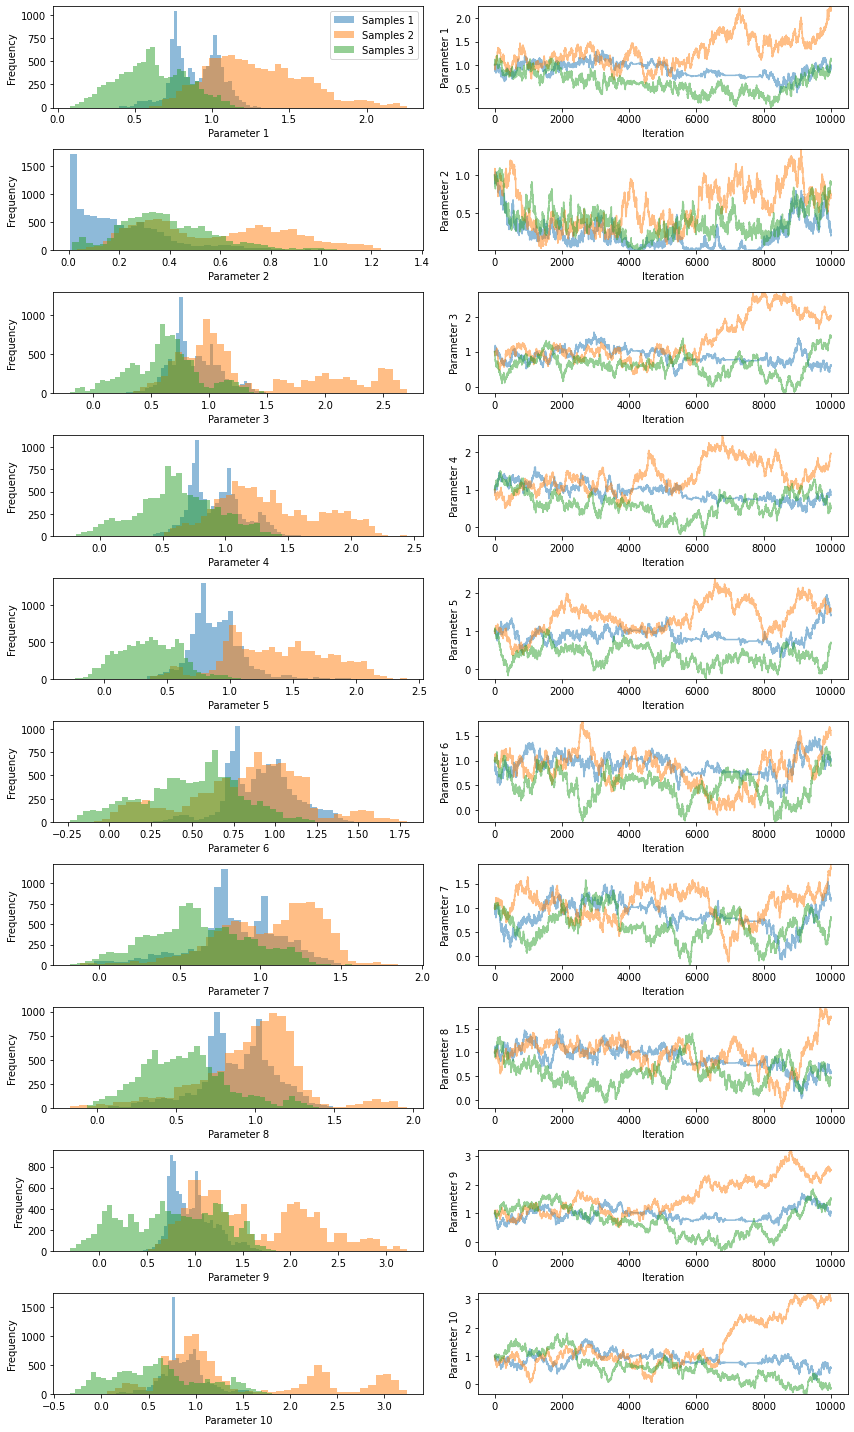

In [17]:
import pints.plot
pints.plot.trace(full_chains)
plt.show()

In [12]:
# MCMC without pints. Self-plagiarised wholesale from Bayesian sampling notebook.

class OdeModel():
    
    def __init__(self, thetas, covariates, prior, likelihood, modeltype):
        self.thetas = thetas
        self.covariates = covariates
        self.modeltype = modeltype
        self.prior = prior
        self.likelihood = likelihood
        
thetas_8schools = [[np.ones(10)], [np.ones(10)*5], [np.ones(10)]]
covariates_8schools = [1,1,5,5,5,5,5,5,5,5]

model = OdeModel(thetas_8schools, 
                 covariates_8schools, 
                 'where prior goes', 
                 loglikelihood_8schools, 
                 'where ODE would go')

model.thetas[0][-1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [8]:
def propose_new_theta(model, y_data, thetas):
    """Randomly proposes a new theta and decides whether to accept or not
    In
    model: instance of OdeModel class
    y_data: list with experimental data
    theta: parameters, in a list
    
    Out: new parameters, either the same (if proposed not accepted) or different
    """
    
    numerator = loglikelihood_8schools(thetas, y_data)
    
    # randomly get a proposed theta & calculate its numerator
    proposed_theta = np.zeros(len(thetas))
    for key, value in enumerate(thetas):
        proposed_k = np.random.normal(value, model.covariates[key])
        proposed_theta[key] = proposed_k
    proposed_numerator = loglikelihood_8schools(proposed_theta, y_data)
    
    # if the new numerator should be accepted (metropolis hastings criteria), replace theta

    if np.random.rand() < proposed_numerator/numerator:
        thetas = proposed_theta
        numerator = proposed_numerator
    else:
        pass # keep thetas the same
    return thetas

In [9]:
def metropolishastings(model, y_data, max_iters):
    iters = 0
    while iters < max_iters:
        for threadnum in range(len(thetas_8schools)):
            theta = propose_new_theta(model, y_data, model.thetas[threadnum][-1])
            model.thetas[threadnum].append(theta)
        iters = iters + 1

In [10]:
metropolishastings(model, theta_data, 500)

/home/simon/anaconda3/envs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


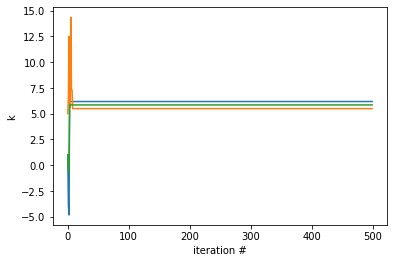

In [11]:
plt.figure()
for n in range(len(model.thetas)):
    ks_list= [theta[3] for theta in model.thetas[n]]
    plt.plot(ks_list[:500]) # only first 500
plt.xlabel('iteration #')
plt.ylabel('k')
plt.show()

[1, 2, 3, 4]